 # Signal acceptance study in different final states and SR

In [1]:
import ROOT
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
print('modules loaded.')

Welcome to JupyROOT 6.26/10
modules loaded.


In [2]:
datestamp = datetime.today().strftime('%Y-%m-%d')
plotdir = 'plots/'+datestamp
os.system(f'mkdir -p {plotdir}')
print('Plot directory ready!')

Plot directory ready!


In [3]:
mass_filtereff_map = {
    100: 0.4369,  
    125: 0.5023, 
    150: 0.5325, 
    200: 0.5634, 
    250: 0.5836, 
    300: 0.5928, 
    350: 0.5996, 
    400: 0.6167
}

# Extrapolate missing values using linear interpolation
masses = sorted(mass_filtereff_map.keys())
filtereff_values = [mass_filtereff_map[m] for m in masses]

# Create interpolation function
interp_func = np.interp

# Define missing mass points
missing_masses = [450, 500, 750, 1000]

# Calculate extrapolated efficiencies
for missing_mass in missing_masses:  mass_filtereff_map[missing_mass] = float(interp_func(missing_mass, masses, filtereff_values))

print('Filter efficiency map ready for VLLS_tau.')
print(mass_filtereff_map)

Filter efficiency map ready for VLLS_tau.
{100: 0.4369, 125: 0.5023, 150: 0.5325, 200: 0.5634, 250: 0.5836, 300: 0.5928, 350: 0.5996, 400: 0.6167, 450: 0.6167, 500: 0.6167, 750: 0.6167, 1000: 0.6167}


In [4]:
channeldict = {
    '1L2J':{'bin':2, 'color':'orange'},
    '2LOS':{'bin':3, 'color':'blue'},
    '2LSS':{'bin':4, 'color':'darkblue'},
    '3L'  :{'bin':5, 'color':'green'},
    '4L'  :{'bin':6, 'color':'red'},
    'mujj':{'bin':7, 'color':'gray'},
    'SR'  :{'bin':8, 'color':'black'}
}

def accp(num, den):
    if den==0 : return 0
    else : return (num/den)

def prepare_dict(jobname, model, map=None):
    indir = 'input_hists/'+jobname
    files = os.listdir(indir)

    plotdict = {}

    for channel, parameters in channeldict.items():

        #Fillup with information from the file
        for filename in files:
            if model in filename:
                
                #This happens for each mass point
                #Extract mass points:
                mass = filename.split(model)[1].split('_M')[1].split('.')[0]
                mass_int = int(mass)

                #Initialize empty dictionaries:
                if channel not in plotdict: plotdict[channel] = {}
                if mass    not in plotdict[channel]: plotdict[channel][mass] = {}

                #Extract efficiencies:
                # Open ROOT file and calculate acceptance:
                tfile = ROOT.TFile(indir + '/' + filename)
                hist = tfile.Get('acceptance_study')

                numerator   = hist.GetBinContent(parameters['bin'])
                denominator = hist.GetBinContent(1)
                acceptance  = accp(numerator, denominator)
                filter_eff = 1.0
                if model == 'VLLS_tau': filter_eff = mass_filtereff_map.get(mass_int, 1.0)
                acceptance2 = acceptance*filter_eff
                    
                #print(channel, mass, acceptance, filter_eff, acceptance2)
                plotdict[channel][mass]['mass_val']    = mass_int
                plotdict[channel][mass]['numerator']   = numerator
                plotdict[channel][mass]['denominator'] = denominator
                plotdict[channel][mass]['filter_eff']  = filter_eff
                plotdict[channel][mass]['acceptance']  = acceptance2
                plotdict[channel]['color'] = parameters['color']
                #break #Mass
                
        #break #Channel

    #print(plotdict)
    return plotdict

In [5]:
dict_vlls_legacy = prepare_dict('hist_SigAccpStudy_mujj_Legacy_Aug14', 'VLLS_legacy')
dict_vlls_tau    = prepare_dict('hist_SigAccpStudy_mujj_UltraLegacy_Aug14', 'VLLS_tau', mass_filtereff_map)
dict_vlls_ele    = prepare_dict('hist_SigAccpStudy_mujj_UltraLegacy_Aug14', 'VLLS_ele')
dict_vlls_mu     = prepare_dict('hist_SigAccpStudy_mujj_UltraLegacy_Aug14', 'VLLS_mu')
dict_vlld_ele    = prepare_dict('hist_SigAccpStudy_mujj_UltraLegacy_Aug14', 'VLLD_ele')
dict_vlld_mu     = prepare_dict('hist_SigAccpStudy_mujj_UltraLegacy_Aug14', 'VLLD_mu')
print('Dictionaries ready.')

Dictionaries ready.


In [6]:
dict_vlls_tau

{'1L2J': {'100': {'mass_val': 100,
   'numerator': 115403.0,
   'denominator': 595015.0,
   'filter_eff': 0.4369,
   'acceptance': 0.08473663806794787},
  'color': 'orange',
  '125': {'mass_val': 125,
   'numerator': 142010.0,
   'denominator': 610843.0,
   'filter_eff': 0.5023,
   'acceptance': 0.11677570668731571},
  '150': {'mass_val': 150,
   'numerator': 170983.0,
   'denominator': 606340.0,
   'filter_eff': 0.5325,
   'acceptance': 0.1501607142857143},
  '200': {'mass_val': 200,
   'numerator': 210601.0,
   'denominator': 605639.0,
   'filter_eff': 0.5634,
   'acceptance': 0.19591308254587303},
  '250': {'mass_val': 250,
   'numerator': 190223.0,
   'denominator': 492706.0,
   'filter_eff': 0.5836,
   'acceptance': 0.2253151834968521},
  '300': {'mass_val': 300,
   'numerator': 203896.0,
   'denominator': 497882.0,
   'filter_eff': 0.5928,
   'acceptance': 0.24276746056294463},
  '350': {'mass_val': 350,
   'numerator': 84013.0,
   'denominator': 197971.0,
   'filter_eff': 0.5996

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mass_vs_acceptance(plotdict, legendheader, filename):

    skip_channels = []
    
    fig, ax = plt.subplots(figsize=(8, 5))


    #Extracting x, y for each chaneel and plotting:
    for channel, parameters in plotdict.items():
        
        if channel in skip_channels: continue

        #default decoration styles:
        lw = 1
        ls = '--'
        mrk =''
        color = parameters['color']
        
        xvals = []
        yvals = []

        sorted_items = sorted(
        ((key, val) for key, val in parameters.items() if isinstance(val, dict) and 'mass_val' in val),
        key=lambda item: item[1]['mass_val']
        )
        
        for key, val in sorted_items:
            if key == 'color': continue
            xvals.append(val['mass_val'])
            yvals.append(val['acceptance'])
        
        #For this channel, x, y vales are ready for plotting.
        #print(f'\n{channel}')
        #print(xvals)
        #print(yvals)

        #Expectional styles:
        if channel in ['1L2J', 'mujj', 'SR']:
            lw = 2
            ls = '-'
            mrk ='o'
        
        ax.plot(xvals, yvals, marker=mrk, linestyle=ls, linewidth=lw, color=color, label=channel)
        
        #break #channel

    #Decorations:
    ax.set_xlabel(r'$M_{\text{VLL}} \; (\text{GeV})$', fontsize=14)
    ax.set_xlim(50, 1050)
    if 'tau' in legendheader: ax.set_xlim(50, 420)
    ax.set_ylabel(r'$A\epsilon$', fontsize=14)
    ax.set_ylim(0, 0.50)
    
    # Add labels, legend, and grid
    #ax.legend(fontsize=12, frameon=True, ncols=1, loc='upper right')
    ax.legend(fontsize=12, frameon=True, loc='upper left', bbox_to_anchor=(1.01, 1))
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Add text annotations
    ax.text(0.04, 0.90, 'CMS', transform=ax.transAxes, fontsize=25, fontweight='bold')
    ax.text(0.23, 0.90, 'preliminary', transform=ax.transAxes, fontsize=18, fontstyle='italic')
    ax.text(0.04, 0.83, legendheader, transform=ax.transAxes, fontsize=12)

    #fig.tight_layout()
    fig.tight_layout(rect=[0, 0, 0.85, 1])

    # Show plot
    plt.savefig(f'{plotdir}/acceptance_{filename}.png', dpi=300)
    plt.show()

print('Plotmaker ready.')

Plotmaker ready.


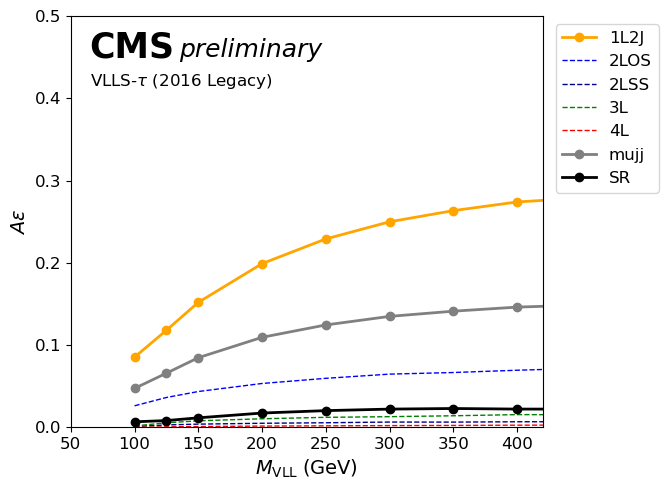

In [8]:
plot_mass_vs_acceptance(dict_vlls_legacy, r'VLLS-$\tau$ (2016 Legacy)', 'vlls_tau_legacy')

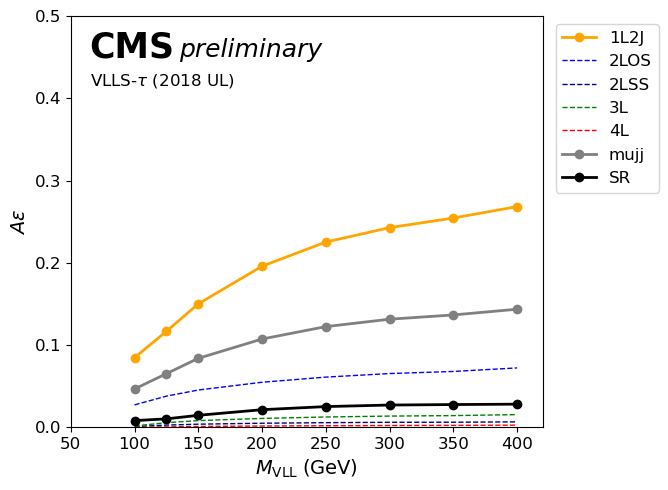

In [9]:
plot_mass_vs_acceptance(dict_vlls_tau, r'VLLS-$\tau$ (2018 UL)', 'vlls_tau')

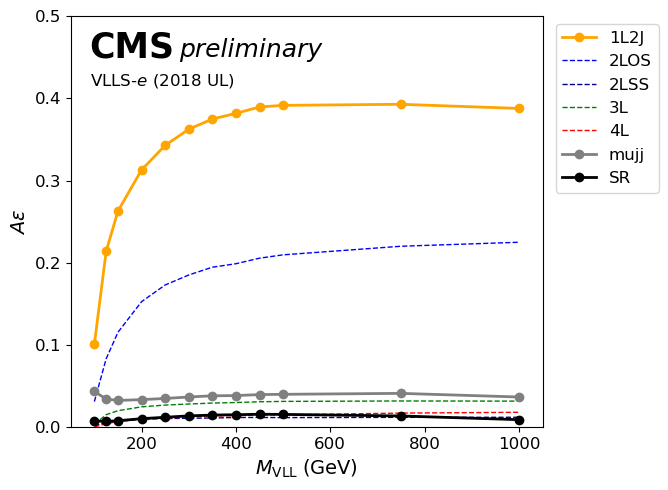

In [10]:
plot_mass_vs_acceptance(dict_vlls_ele, r'VLLS-$e$ (2018 UL)', 'vlls_ele')

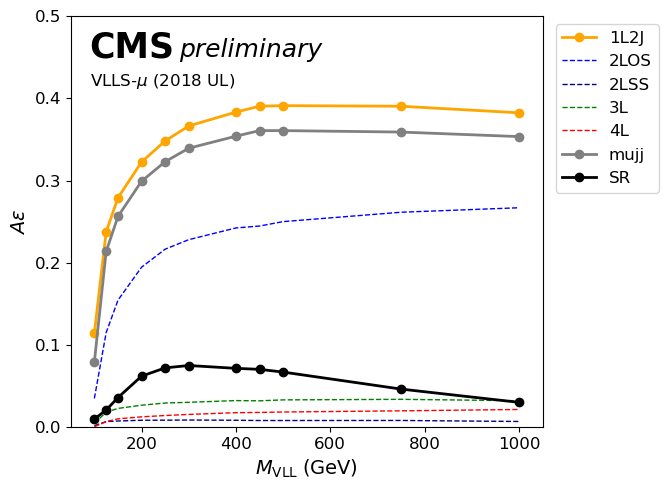

In [11]:
plot_mass_vs_acceptance(dict_vlls_mu, r'VLLS-$\mu$ (2018 UL)', 'vlls_mu')

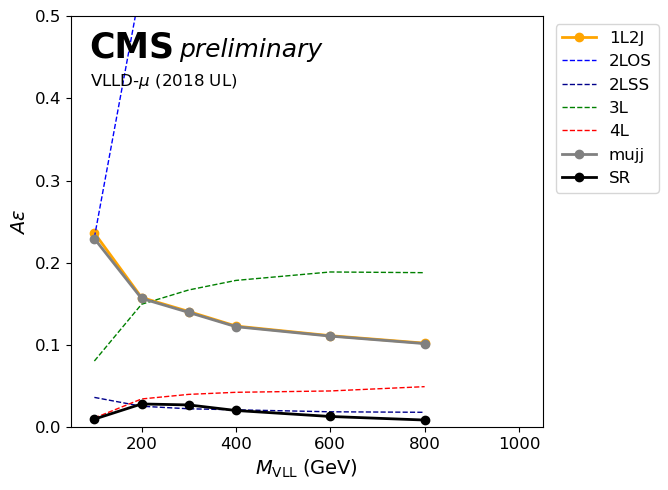

In [12]:
plot_mass_vs_acceptance(dict_vlld_mu, r'VLLD-$\mu$ (2018 UL)', 'vlld_mu')

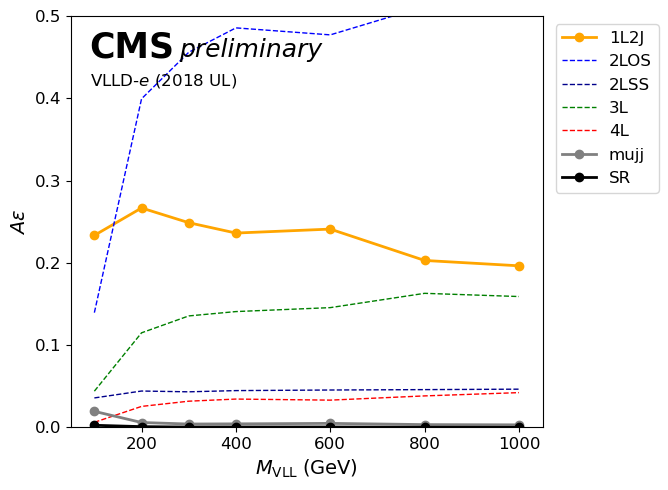

In [13]:
plot_mass_vs_acceptance(dict_vlld_ele, r'VLLD-$e$ (2018 UL)', 'vlld_ele')